In [94]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import DistanceMetric, silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN # а также другие алгоритмы
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances 

In [2]:
DATA_PATH = "/home/pseudocephalus/BI/ML/HW3_UL/data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

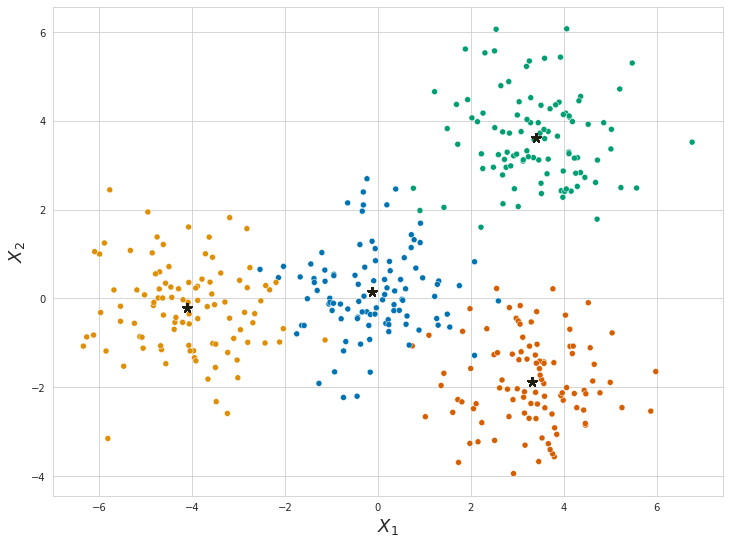

In [5]:
visualize_clusters(X, true_labels) # эй!..

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        dists = []
        for centroid in self.centroids:
                dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
                        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist_sklearn = euclidean_distances(X, centroid.reshape(1,-1))
        dist = np.sqrt(np.sum(np.power(np.subtract(X, centroid), 2), axis=1)).reshape(-1,1)
        
        assert np.all(np.isclose(dist_sklearn, dist)), 'здравствуйте'
        
        return dist 
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

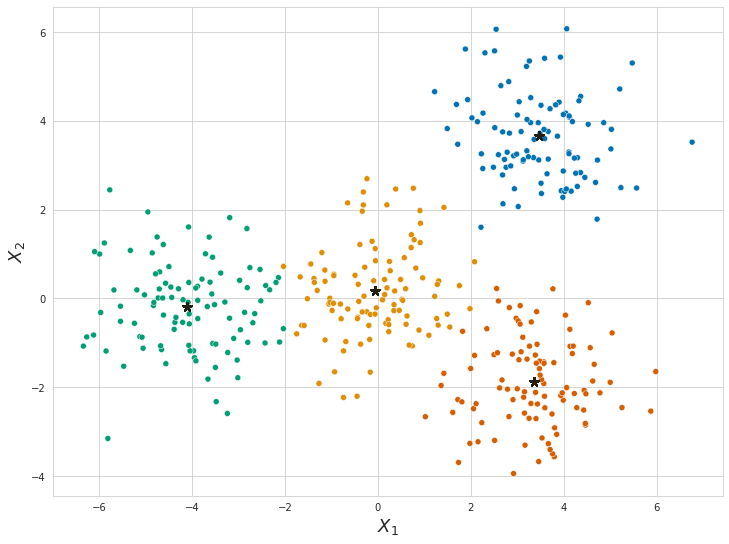

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
km = MyKMeans(n_clusters=4, max_iter=5, visualize=True, init='random')
km.fit(X)

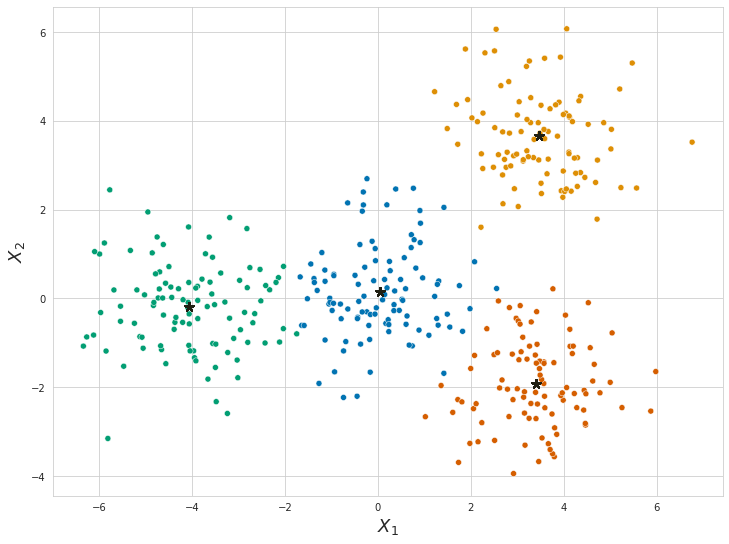

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
km = MyKMeans(n_clusters=4, max_iter=5, visualize=True, init='sample')
km.fit(X)

Оба варианта обычно сходятся меньше, чем за 5 итераций

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target


In [10]:
# Эксперимент со стандартизацией
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

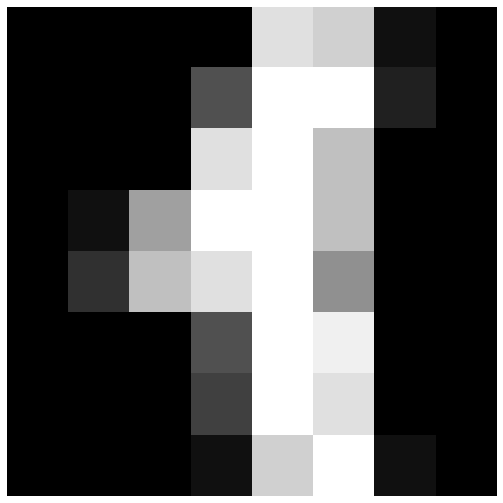

In [11]:
plt.imshow(X[11].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE 
Не понравилось условие, что метрики должны подаваться списком: гораздо проще было бы итерировать функции  метрик, переданные в виде аргумента, в заранее известном порядке. Смысла в списке никакого (мы всегда хотим все  возможные метрики?)

In [56]:
def algorithm_selection(X, distances, algorithms, metrics, n_clusters):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    # списки для записи результатов
    distance = []
    linkage = []
    homogeneity = []
    completeness = []
    v_measure = []
    silhouette = []
    compare_dataframe = pd.DataFrame() 
        
    for d in distances:
        for a in algorithms:
            
            linkage.append(a)
            distance.append(d)
            
            # вычисляем попарные расстояния
            dist = DistanceMetric.get_metric(d).pairwise(X) if d != 'cosine' else cosine_distances(X)
            
            # фитим модель
            estimator = AgglomerativeClustering(n_clusters=n_clusters, linkage=a, metric='precomputed')
            labels = estimator.fit_predict(dist)
            
            for m in metrics: 
                compare_dataframe[m] = None
                
                # проверка заданной метрики.
                # Если бы подавалось не списком названий, а списком функций, можно было бы избежать условий вообще
                # (использовать заранее заданный порядок метрик)
                
                assert m in ['silhouette', 'homogeneity',
                             'completeness', 'v_measure'], f'"{m}" is an unknown metric'
                
                if m == 'silhouette':
                    silhouette.append(silhouette_score(X, labels))
                elif m == 'homogeneity':
                    homogeneity.append(homogeneity_score(labels, y))
                elif m == 'completeness':
                    completeness.append(completeness_score(labels, y))
                elif m == 'v_measure':
                    v_measure.append(v_measure_score(labels, y))

    compare_dataframe['distance'] = distance
    compare_dataframe['metric'] = linkage
    
    # Добавление столбцов в зависимости от поданных метрик, для использование с меньшим количеством метрик
    if silhouette:
        compare_dataframe['silhouette'] = silhouette
    if homogeneity:
        compare_dataframe['homogeneity'] = homogeneity
    if completeness:
        compare_dataframe['completeness'] = completeness
    if v_measure:
        compare_dataframe['v_measure'] = v_measure
        
    return compare_dataframe.sort_values('silhouette', ascending=False) 

<AxesSubplot:>

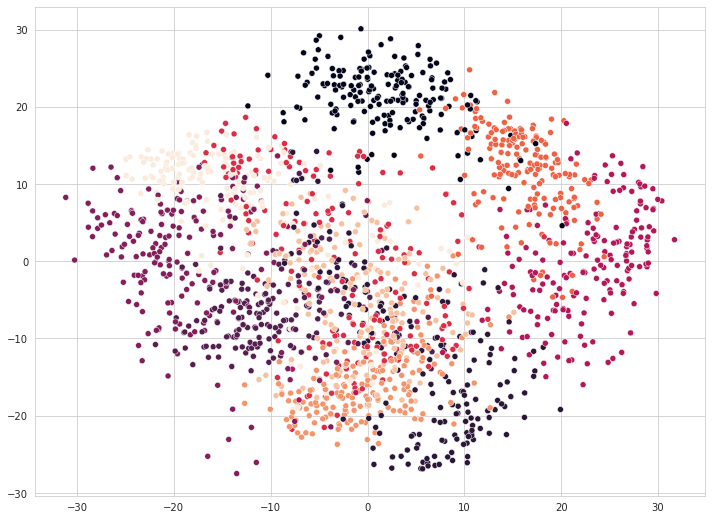

In [42]:
# Визуализация на скорую руку - нестандартизированные данные
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], c=y)

<AxesSubplot:>

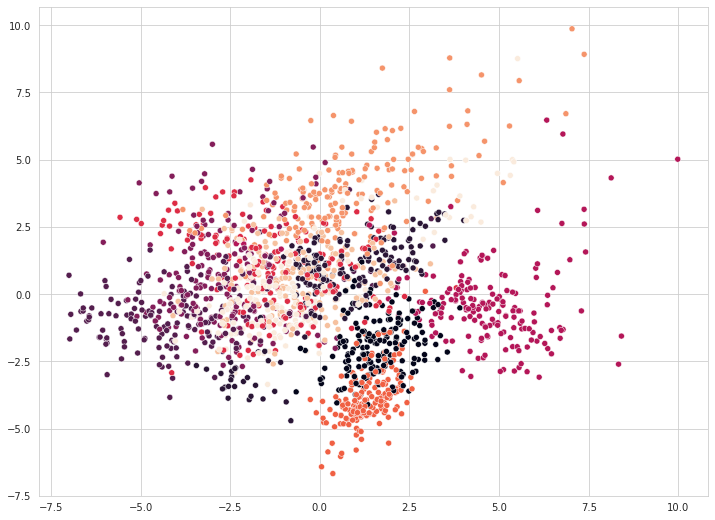

In [14]:
# Визуализация на скорую руку - стандартизированные данные
pca = PCA(n_components=2)
X_pca_std = pca.fit_transform(X_std)
sns.scatterplot(x=X_pca_std[:,0], y=X_pca_std[:,1], c=y)

In [57]:
# скоры на нестандартизированных данных - 
distances = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['silhouette', 'homogeneity', 'completeness', 'v_measure']

algorithm_selection(X, distances, algorithms, metrics, n_clusters=10)

silhouette  homogeneity  completeness  v_measure   distance    metric
9     0.173900     0.828645      0.769464   0.797959  chebyshev   average
0     0.146625     0.782342      0.655393   0.713263  euclidean   average
6     0.146625     0.782342      0.655393   0.713263  minkowski   average
5     0.140183     0.686109      0.646372   0.665648  manhattan  complete
12    0.129526     0.808762      0.648268   0.719676     cosine   average
2     0.119271     0.637772      0.590549   0.613253  euclidean  complete
8     0.119271     0.637772      0.590549   0.613253  minkowski  complete
3     0.089217     0.778942      0.566751   0.656117  manhattan   average
14    0.088021     0.577415      0.528727   0.551999     cosine  complete
10   -0.087260     0.281430      0.006129   0.011996  chebyshev    single
1    -0.133621     0.273755      0.005056   0.009929  euclidean    single
7    -0.133621     0.273755      0.005056   0.009929  minkowski    single
13   -0.158250     0.273389      0.005050   0.009916     cosine    single
4    -0.166627     0.276237      0.005102   0.010019  manhattan    single
11   -0.193835     0.412582      0.067111   0.115444  chebyshev  complete

In [58]:
# скоры на стандартизированных данных - 
distances = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['silhouette', 'homogeneity', 'completeness', 'v_measure']

algorithm_selection(X_std, distances, algorithms, metrics, n_clusters=10)

silhouette  homogeneity  completeness  v_measure   distance    metric
4     0.537956     0.276224      0.005576   0.010932  manhattan    single
0     0.531732     0.237556      0.007132   0.013848  euclidean   average
6     0.531732     0.237556      0.007132   0.013848  minkowski   average
1     0.471120     0.276361      0.005579   0.010937  euclidean    single
7     0.471120     0.276361      0.005579   0.010937  minkowski    single
10    0.471120     0.276361      0.005579   0.010937  chebyshev    single
9     0.456320     0.245507      0.008116   0.015712  chebyshev   average
11    0.401877     0.274233      0.012128   0.023229  chebyshev  complete
2     0.385738     0.248975      0.016848   0.031561  euclidean  complete
8     0.385738     0.248975      0.016848   0.031561  minkowski  complete
3     0.361351     0.301161      0.017545   0.033157  manhattan   average
12    0.101366     0.763472      0.677977   0.718189     cosine   average
14    0.067073     0.602174      0.581801   0.591812     cosine  complete
5     0.062376     0.474143      0.290562   0.360317  manhattan  complete
13   -0.201896     0.191574      0.006009   0.011652     cosine    single

<AxesSubplot:>

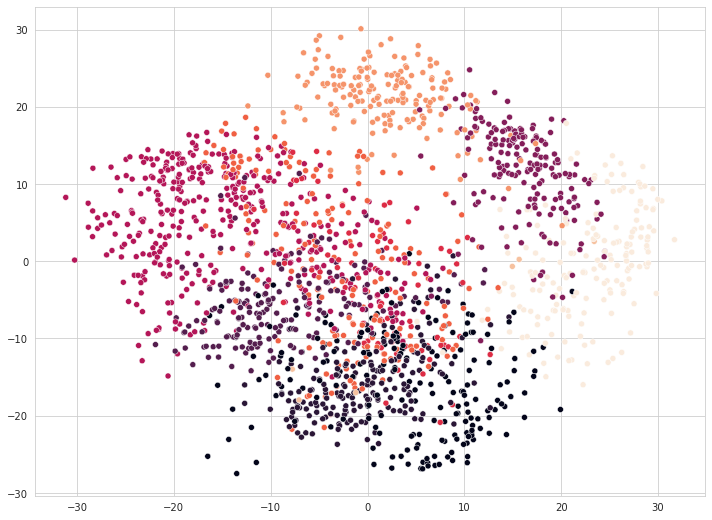

In [17]:
# лучший результат (?) - разбилось весьма похоже на оригинал
estimator = AgglomerativeClustering(n_clusters=10, linkage='average', metric='chebyshev')
labels = estimator.fit_predict(X)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], c=labels)


Не понятно, помогла стандартизация или нет - pca выглядят одинаково смешанными, одни скоры лучше на стандартизированных данных, а другие - на нестандартизированных.

На нестандартизированных данных лучше работает расстояние Чебышева и average linkage. На стандартизированных, по оценке силуета, манхэттенское расстояние с single linkage. 

Общий вывод зависит от того, какой скор мы хотим максимизировать. Пока кажется, что без стандартизации, 

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [18]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [105]:
fc_data.head() # Это явно лейкоциты

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

Данные как-то центрированы (много наблюдений с отрицательными значениями экспрессии), но не стандартизированы

In [106]:
fc_data.describe() 

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

у всех данных очень большой размах, что соответсвует предположению, что разные типы клеток демонстрируют различную экспрессию разных генов, поэтому никогда большинство наблюдений не группируется около среднего значения экспрессии одного гена. Распределения похожи что-то вроде нормального, но 

<AxesSubplot:>

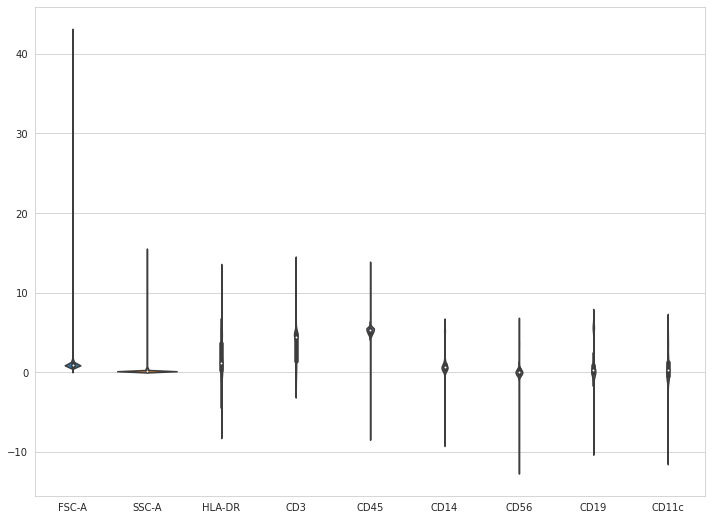

In [111]:
sns.violinplot(data=fc_data) 


Большинство генов имеют две моды - отражает экспрессию у разных клеток. Распределения вокруг мод похожи на что-то вроде нормальных. Корреляции между переменными, кажется, нет вообще.

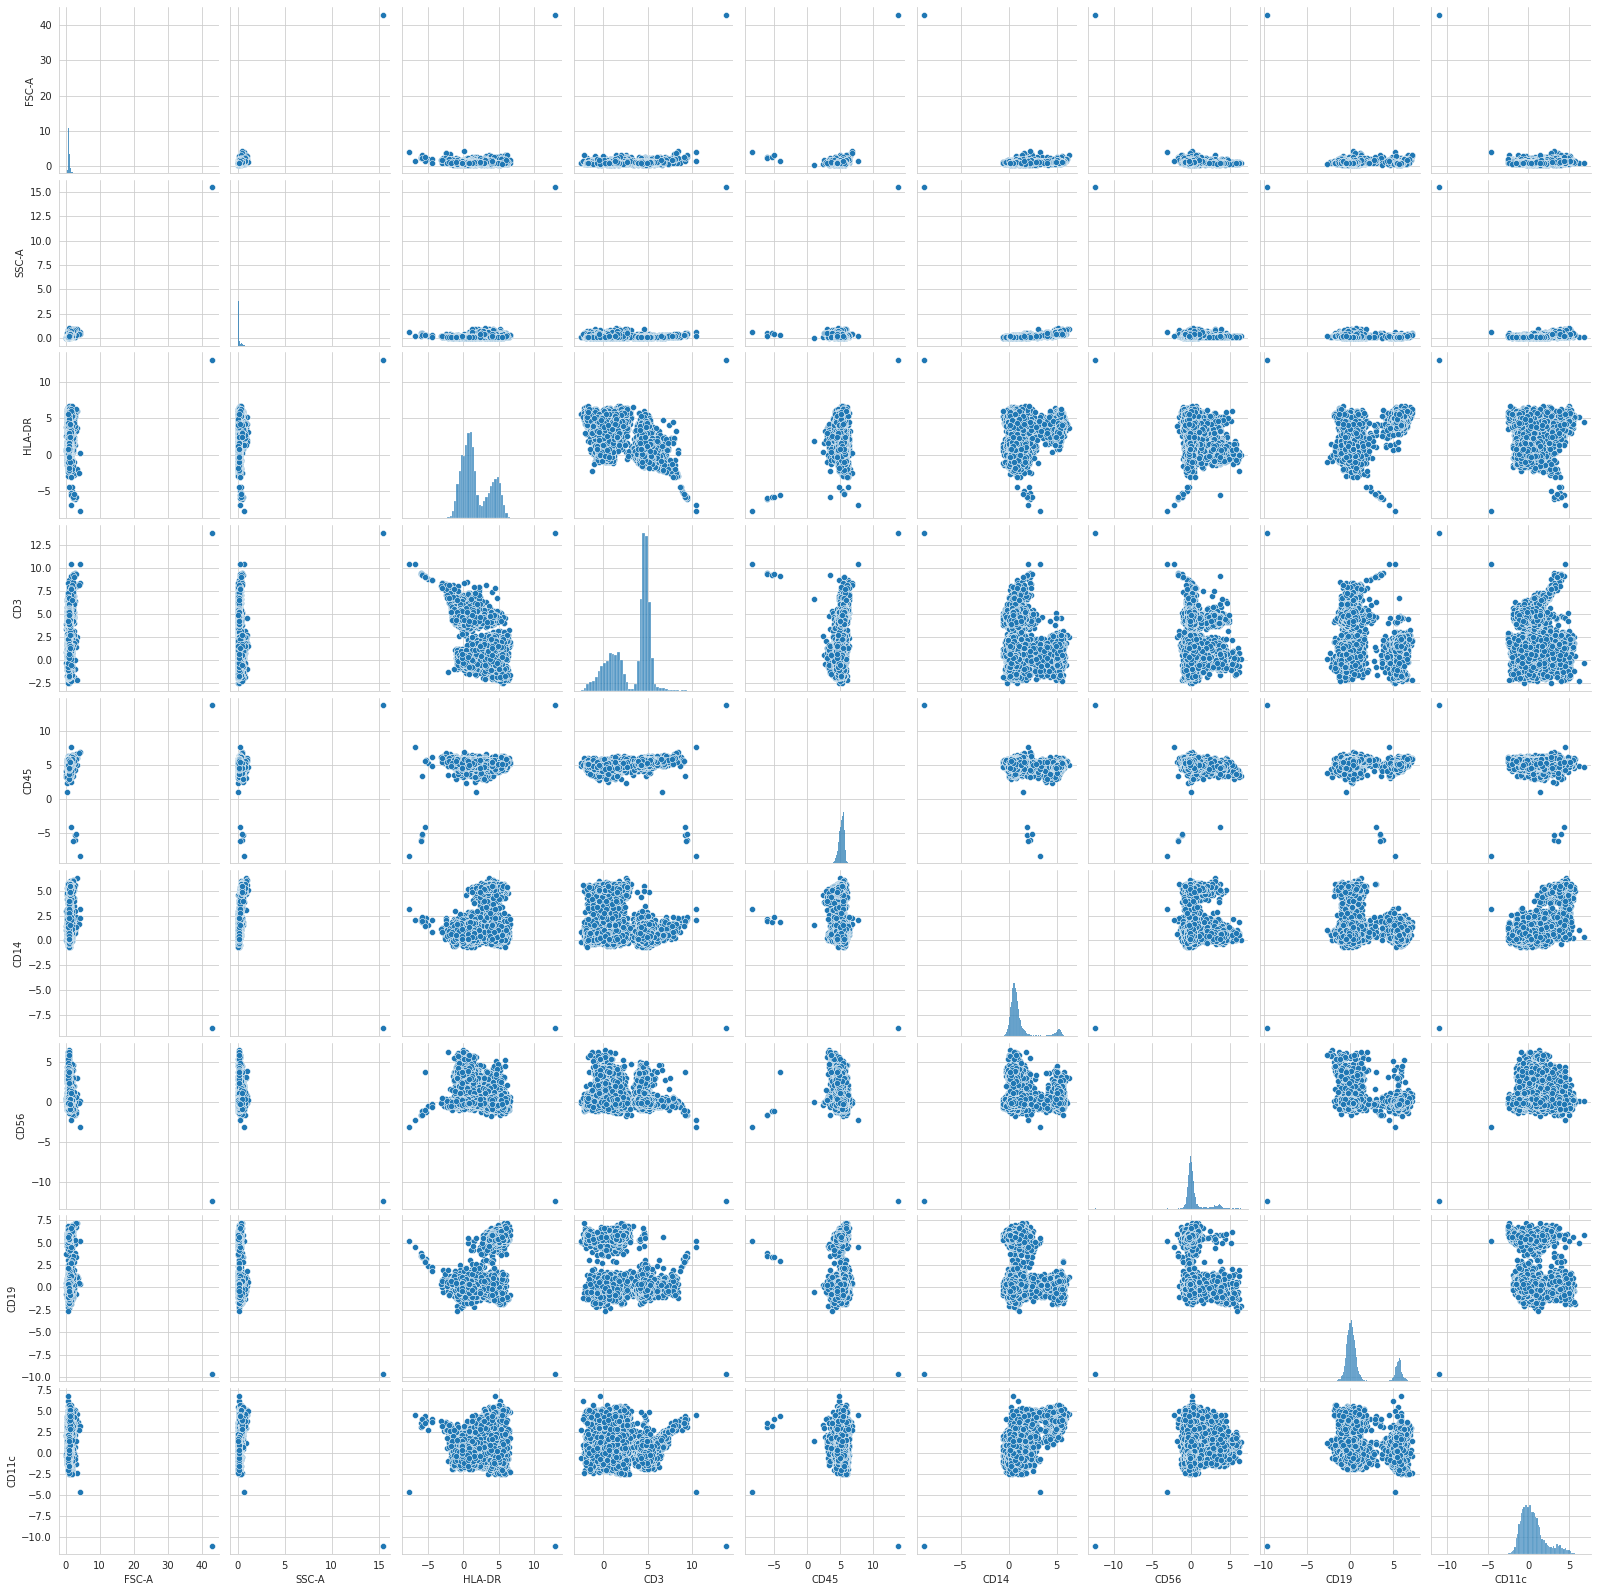

In [122]:
sns.pairplot(data=fc_data) 

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [230]:
def plot_tsne(data, n_iter=300, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

In [37]:
fc_std = StandardScaler().fit_transform(fc_data)

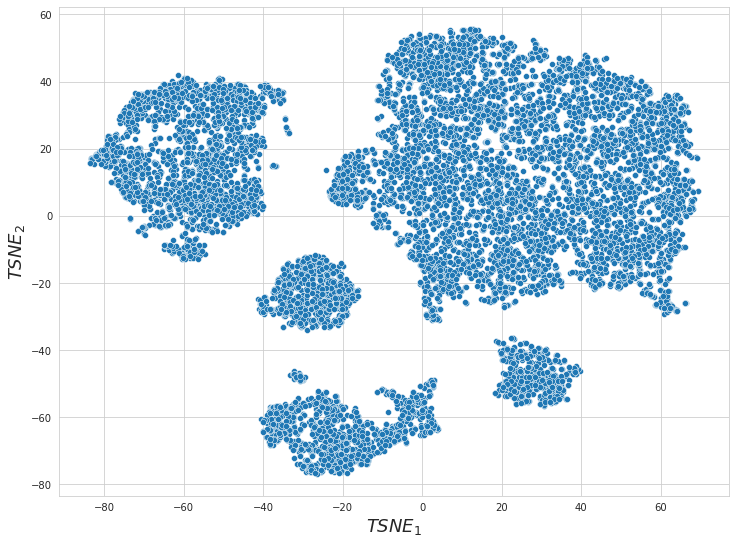

In [39]:
tsne_res = plot_tsne(fc_data) # на вид 5 кластеров

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

### KMeans

In [30]:
# настройка гиперпараметров KMeans
silhouette = []
n_iter = []
algorithm = []
init = []
n_clusters =[]
for n in range(100,501,100):
    for a in ['elkan', 'lloyd']:
        for i in ['k-means++', 'random']:
            for c in range(2,7):
                km = KMeans(n_clusters=4, algorithm=a, max_iter=n, init=i)
                km.fit(fc_data)
                silhouette.append(silhouette_score(fc_data, km.labels_))
                n_iter.append(n)
                algorithm.append(a)
                init.append(i)
                n_clusters.append(c)


In [33]:
df = pd.DataFrame({'n_clusters': n_clusters, 'max_iter': n_iter, 'algorithm': algorithm,
              'init': init, 'silhouette score': silhouette}).sort_values('silhouette score', ascending = False)
df.head()
# ничего не меняется   

n_clusters  max_iter algorithm       init  silhouette score
0            2       100     elkan  k-means++          0.610301
62           4       400     elkan  k-means++          0.610301
34           6       200     lloyd  k-means++          0.610301
41           3       300     elkan  k-means++          0.610301
42           4       300     elkan  k-means++          0.610301

array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

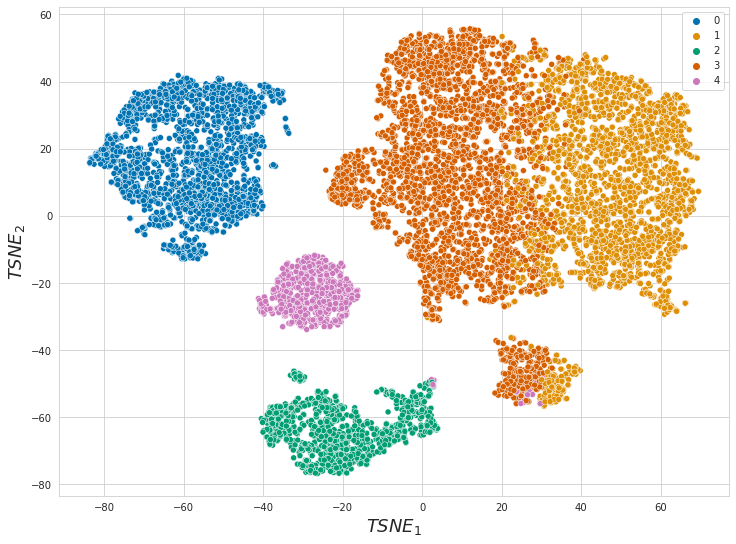

In [65]:
# визуализация KMeans - 5 кластеров - предсказывается не очень, и очевидно из следующего задания, что их 4
km = KMeans(n_clusters=5, algorithm='elkan', max_iter=100, init='k-means++')
labels=km.fit_predict(fc_data)
plot_tsne(fc_data, color=labels)

0.6103014000983125


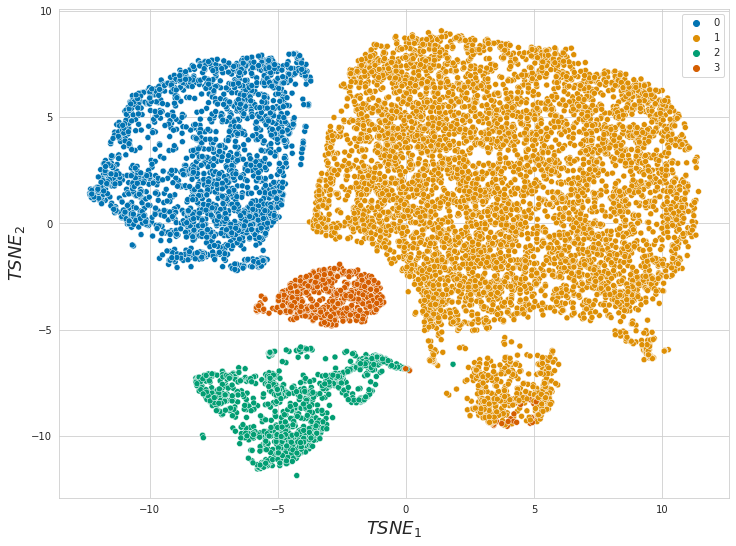

In [231]:
# визуализация KMeans - 4 кластера 
km = KMeans(n_clusters=4, algorithm='elkan', max_iter=100, init='k-means++')
labels=km.fit(fc_data).labels_
plot_tsne(fc_data, color=labels)
print(silhouette_score(fc_data, labels))


0.5010743968681938


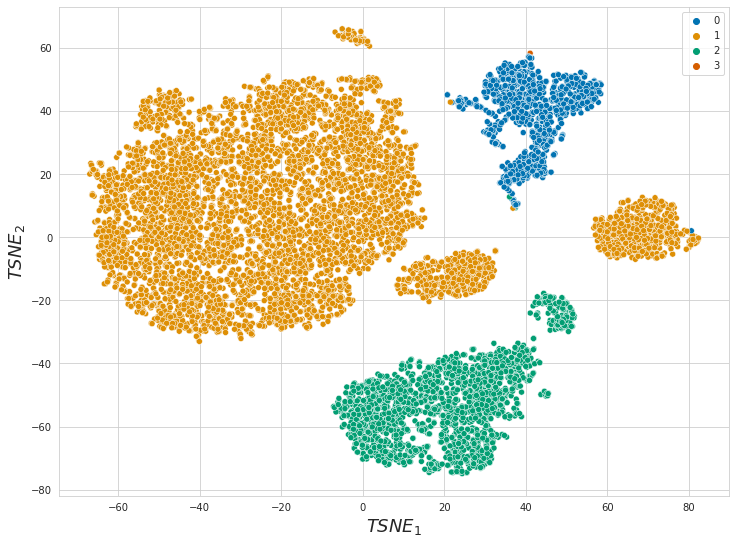

In [52]:
# визуализация KMeans - 4 кластера, стандартизированные данные
km = KMeans(n_clusters=4, algorithm='elkan', max_iter=100, init='k-means++')
labels=km.fit(fc_std).labels_
plot_tsne(fc_std, color=labels)
print(silhouette_score(fc_std, labels)) # на стандартизированных данных скор хуже

### Agglomerative

In [71]:
# Подбор параметров для аггломеративной кластеризации - 4 кластера 
# Оказалось бесполезно - подбирать с distance_treshold на этих данных оказывается слишком долго
distances = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['silhouette']

algorithm_selection(fc_data, distances, algorithms, metrics, n_clusters=4)

silhouette   distance    metric
0     0.654419  euclidean   average
1     0.654419  euclidean    single
4     0.654419  manhattan    single
6     0.654419  minkowski   average
7     0.654419  minkowski    single
9     0.654419  chebyshev   average
10    0.654419  chebyshev    single
13    0.654419     cosine    single
3     0.578442  manhattan   average
5     0.578442  manhattan  complete
12    0.538403     cosine   average
14    0.519039     cosine  complete
11    0.496353  chebyshev  complete
2     0.307133  euclidean  complete
8     0.307133  minkowski  complete

0.6074543914873192


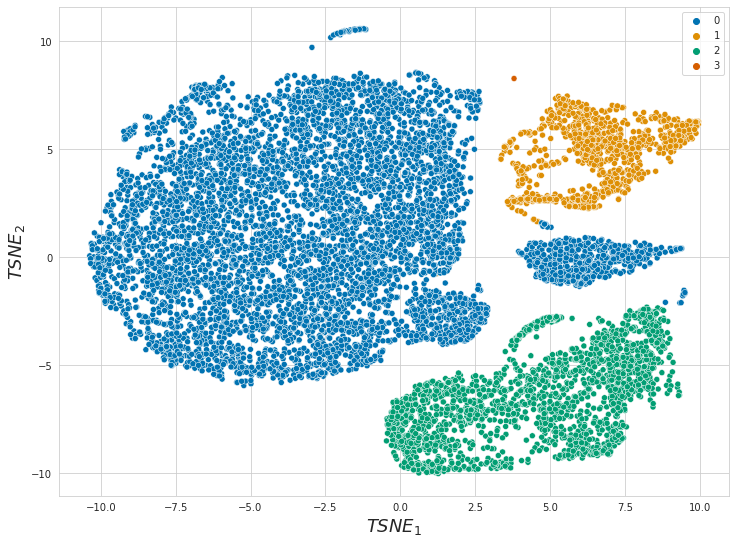

In [232]:
agg = AgglomerativeClustering(n_clusters=4) # на стандартизированных данных 
agg_labels=agg.fit_predict(fc_std)
plot_tsne(fc_std, color=agg_labels)

# скор хуже, чем без стандартизации
print(silhouette_score(fc_data, agg_labels)) 


0.6114468221314616

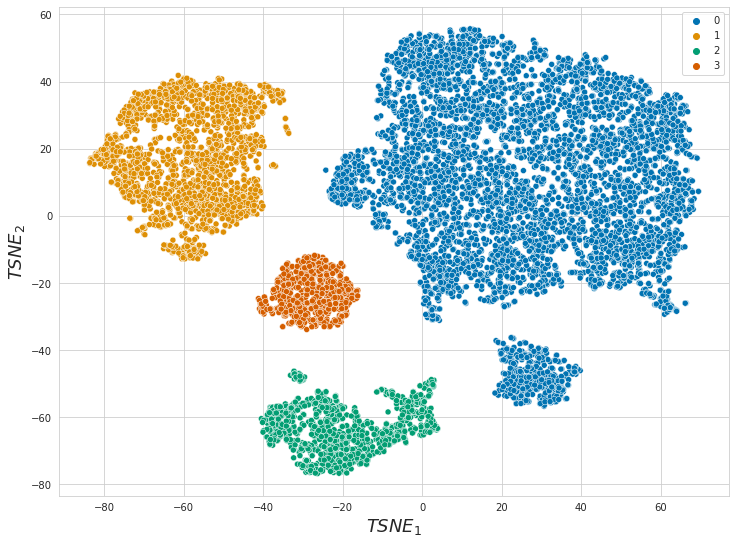

In [140]:
agg = AgglomerativeClustering(n_clusters=4) # после подбора distance_treshold вручную, это оказалось лучшей моделью
agg_labels=agg.fit_predict(fc_data)
plot_tsne(fc_data, color=agg_labels)

# скор больше, чем у KMeans
silhouette_score(fc_data, agg_labels) 



In [142]:
best_labels = agg_labels

### DBSCAN

In [131]:
# подбор параметров
epses = []
scores = []
for eps in [1, 2, 2.1, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3]:
    epses.append(eps)
    db = DBSCAN(eps = eps, min_samples = 50)
    labels = db.fit_predict(fc_data)
    scores.append(silhouette_score(fc_data, labels))


In [132]:
dfdb = pd.DataFrame({'eps': epses, 'score': scores})
dfdb

eps     score
0   1.0  0.355788
1   2.0  0.604958
2   2.1  0.605945
3   2.3  0.608261
4   2.4  0.608598
5   2.5  0.608991
6   2.6  0.528042
7   2.7  0.528342
8   2.8  0.528612
9   2.9  0.528727
10  3.0  0.528923

array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

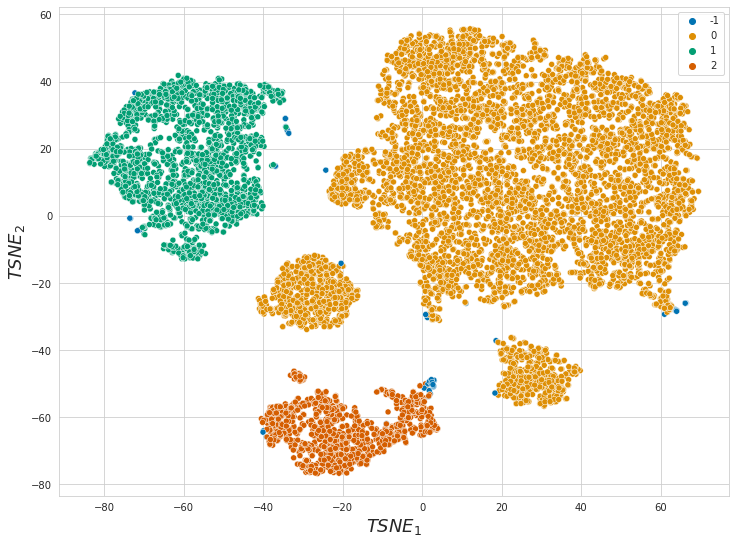

In [138]:
db = DBSCAN(eps=2.5, min_samples=50)
db_labels = db.fit_predict(fc_data)
plot_tsne(fc_data, color=db_labels)

In [139]:
silhouette_score(fc_data, db_labels) # хуже всех

0.6089910415339146

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

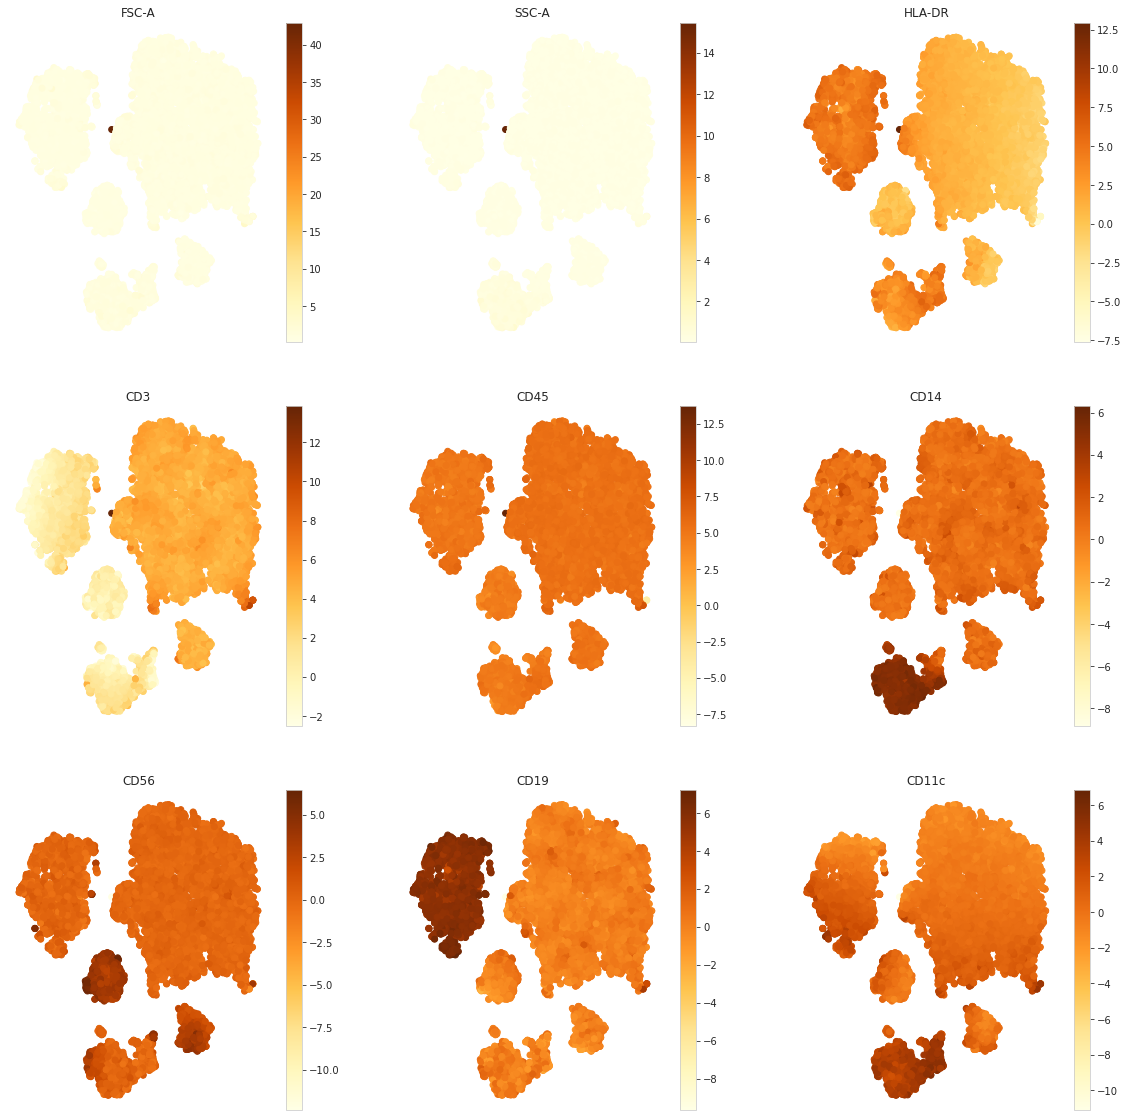

In [116]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

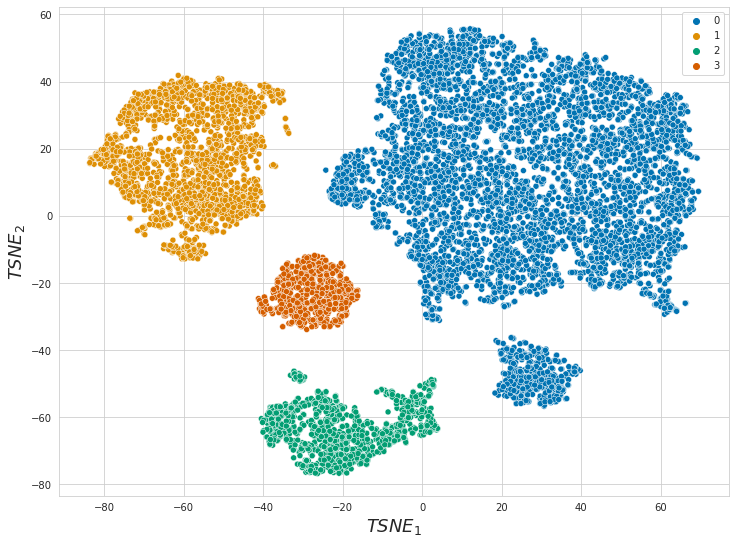

In [144]:
# ещё раз лучшая картинка от AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=4)
agg_labels=agg.fit_predict(fc_data)
plot_tsne(fc_data, color=agg_labels)


In [145]:
cell_type_cluster_map = {0: "T_cells",       # CD3+ CD56+
                         1: "B_cells",       # CD19+ MHCII+
                         2: "Monocytes",     # CD14+ MHCII+c CD11c+
                         3: "Other cells"}   # CD3- CD56+ 

In [146]:
labeled_fc_data = fc_data.assign(Population=best_labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

array([[-34.95752484, -26.40343595],
       [-53.2428646 ,  19.86096661],
       [ 52.03633642,  20.00618972],
       ...,
       [ -1.61745392, -53.89400762],
       [-27.48943831, -20.29162396],
       [-33.60576566, -20.35721593]])

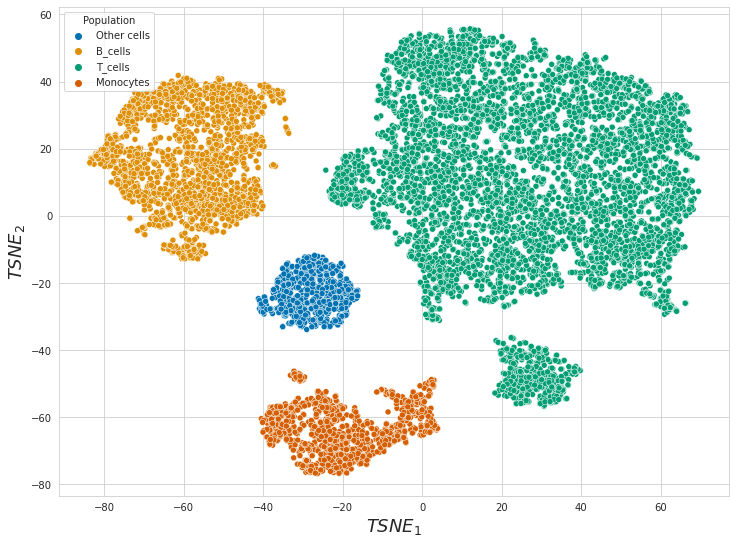

In [149]:
plot_tsne(fc_data, color = labeled_fc_data['Population']) # проверим, что всё нормально аннотировалось

<AxesSubplot:xlabel='Population', ylabel='Count'>

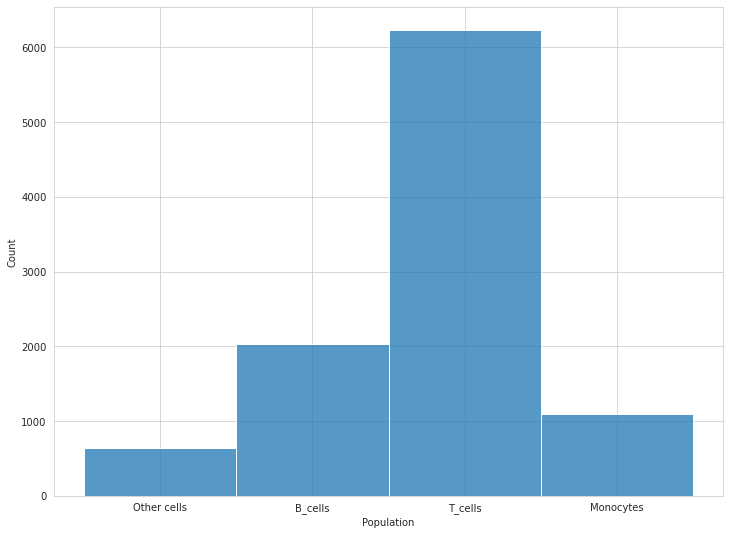

In [150]:
sns.histplot(labeled_fc_data['Population'])

In [161]:
pd.DataFrame({pop: [np.sum(labeled_fc_data['Population']==pop)] 
              for pop in np.unique(labeled_fc_data['Population'])})

B_cells  Monocytes  Other cells  T_cells
0     2035       1099          635     6231

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [163]:
labeled_fc_data.to_csv('labeled_fc_data.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

#### Я вроде бы разобрался с тем, как считается AUC для мультиклассовой классификации и попробовал несколько подходов (оставил самый базовый One vs Rest, без рисования графика для каждого класса отдельно), и то ,что в любом случае AUC и accuracy оказываются = 1 меня очень смутило. Морально готов к 0 баллов

In [223]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, RocCurveDisplay, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier


Как подсказано в статье - сделал датасет, где равное количество наблюдений каждого класса

In [224]:
from sklearn.utils import resample
tcells = resample(labeled_fc_data[labeled_fc_data.Population == 'T_cells'], replace=True, n_samples=635)
bcells = resample(labeled_fc_data[labeled_fc_data.Population == 'B_cells'], replace=True, n_samples=635)
mono = resample(labeled_fc_data[labeled_fc_data.Population == 'Monocytes'], replace=True, n_samples=635)
other = labeled_fc_data[labeled_fc_data.Population == 'Other cells'] # 635


fc_downsampled = pd.concat([tcells, bcells, mono, other])

<AxesSubplot:xlabel='Population', ylabel='Count'>

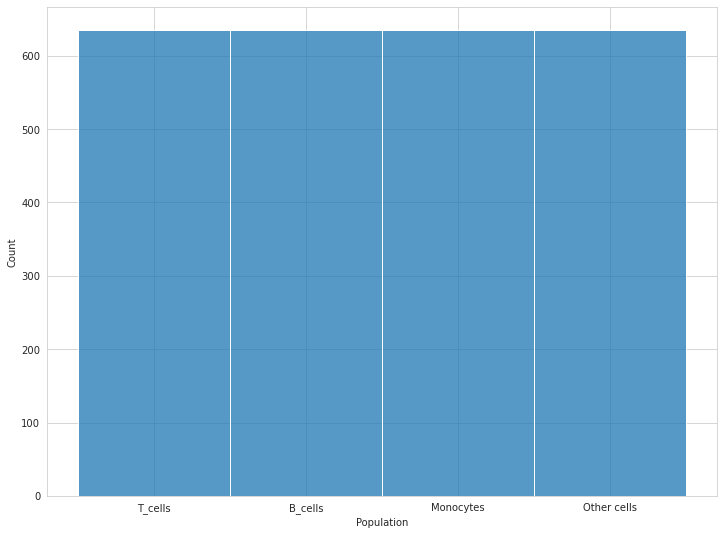

In [194]:
sns.histplot(fc_downsampled['Population'])

In [225]:

X = fc_downsampled.drop('Population', axis=1)
y = fc_downsampled['Population']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=13)


Accuracy core is 1.0


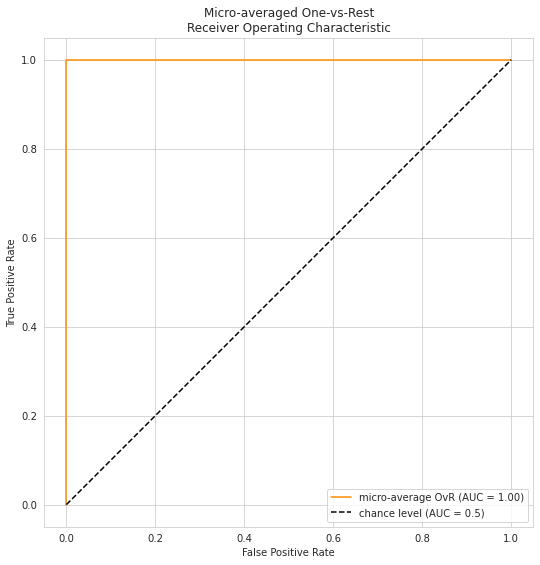

In [214]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# Логистическая регрессия 

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(f'Accuracy core is {accuracy_score(y_pred, y_test)}')

# тестовые и предсказанные классы кодируются как onehot и разворачиваются в одномерный эррей 
# - это дает бинарное представление, подходящее для ROC

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

y_score = classifier.predict_proba(X_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Accuracy core is 0.99880810488677


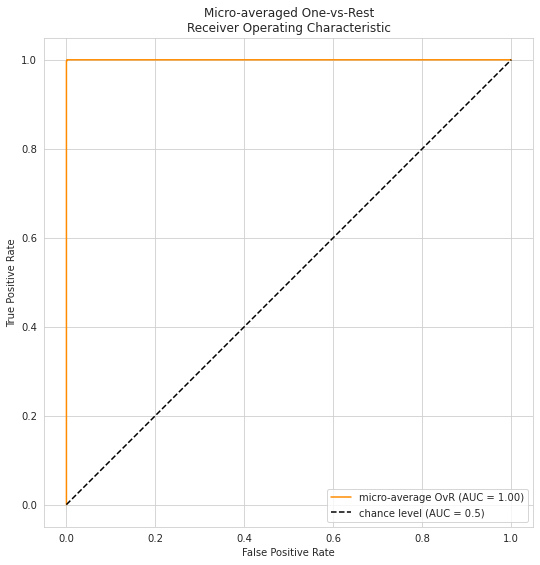

In [220]:
# K neighbors classifier

classifier = KNeighborsClassifier(n_neighbors=100) # метрики не зависят от k
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(f'Accuracy core is {accuracy_score(y_pred, y_test)}')

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

y_score = classifier.predict_proba(X_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Accuracy core is 1.0


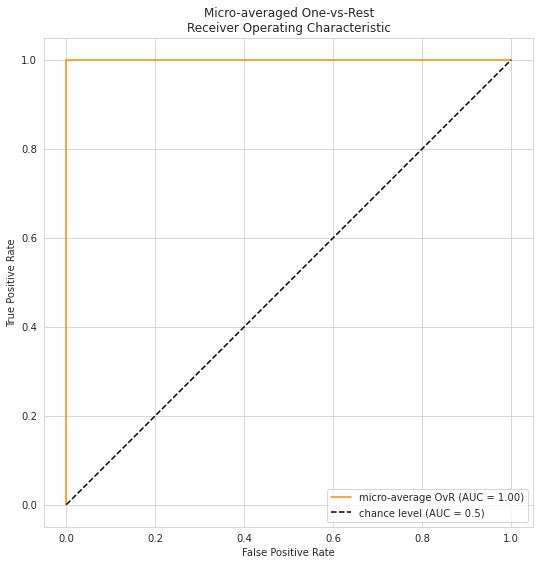

In [221]:
# Random forest classifier - используем его в семестровом проекте

classifier = RandomForestClassifier(n_estimators=999, random_state=13)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(f'Accuracy core is {accuracy_score(y_pred, y_test)}')

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

y_score = classifier.predict_proba(X_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

##### Мне нравятся заброшенные посёлки ленинградской области - подойдёт любой. Всем рекомендую!

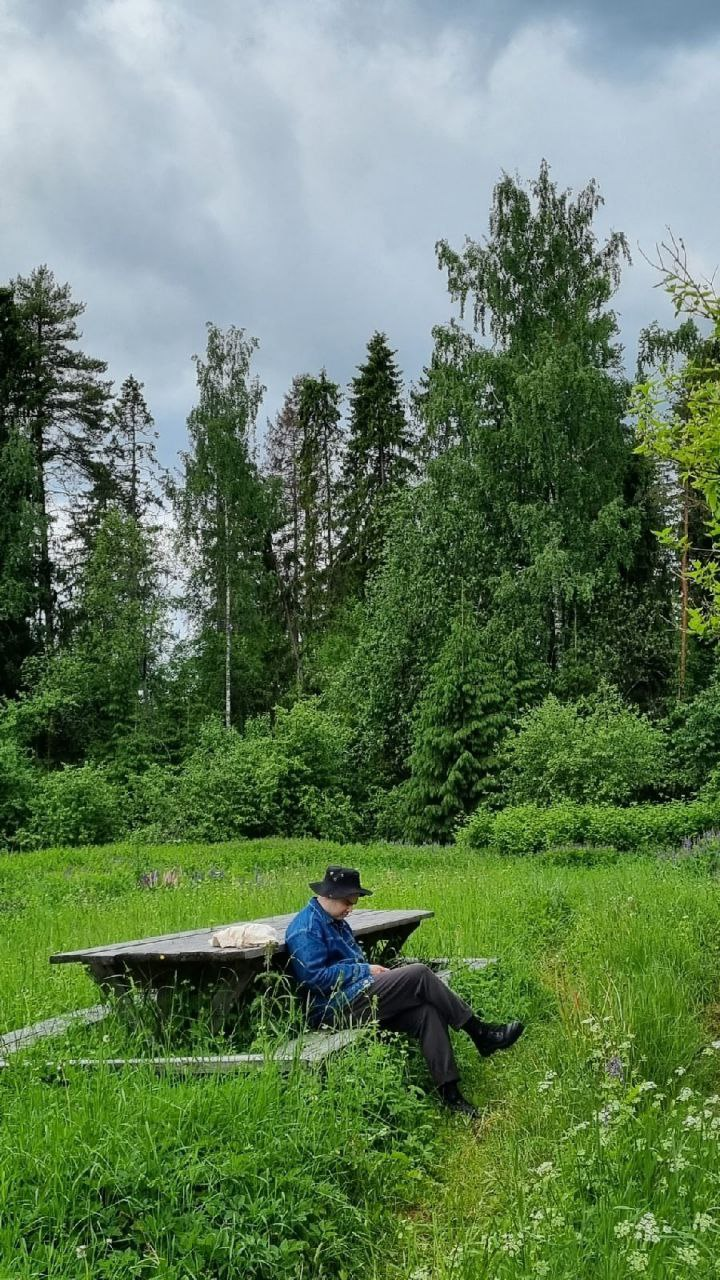